In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

import squarify as sq

import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

import urllib
from io import BytesIO 
import requests

import warnings
warnings.filterwarnings('ignore')

C:\Users\Sahar Farhat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Sahar Farhat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
data= pd.read_csv('femicide_in_turkey_2008_2020_englishdataset.csv')
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 1000)
data.head()

,id,city,age,date,protectionorder,why1,why2,killer1,killer2,killingway1,killingway2,killingway3,statusofkiller,year
0,1,Adana,Adult,01/02/2008,Undetectable,Because something that a man wanted did not ha...,NaN,Husband,NaN,Firearm,NaN,NaN,NaN,2008.0
1,2,Adana,NaN,01/12/2008,No,Undetectable,NaN,Boyfriend,NaN,Firearm,NaN,NaN,Suicide,2008.0
2,3,Adana,Underage,01/02/2008,No,Undetectable,NaN,Father,NaN,Assault,NaN,NaN,Prisoner,2008.0
3,4,Adana,NaN,01/04/2008,No,Undetectable,NaN,Ex Boyfriend,NaN,Firearm,NaN,NaN,Suicide,2008.0
4,5,Ankara,NaN,01/12/2008,Undetectable,Undetectable,NaN,Undetectable,NaN,Undetectable,NaN,NaN,Undetectable,2008.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3111 entries, 0 to 3110
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3111 non-null   int64  
 1   city             1931 non-null   object 
 2   age              1320 non-null   object 
 3   date             3111 non-null   object 
 4   protectionorder  3109 non-null   object 
 5   why1             3110 non-null   object 
 6   why2             70 non-null     object 
 7   killer1          3108 non-null   object 
 8   killer2          9 non-null      object 
 9   killingway1      3111 non-null   object 
 10  killingway2      67 non-null     object 
 11  killingway3      6 non-null      object 
 12  statusofkiller   1769 non-null   object 
 13  year             3111 non-null   float64
dtypes: float64(1), int64(1), object(12)
memory usage: 340.4+ KB


There are some feature that needs type correction

### Data Cleaning

In [5]:
data = data.replace({"^\s*|\s*$":""}, regex=True)
year = data['year'] = data['year'].astype('int') 
data['city'] = data['city'].astype('str')
data = data.replace('Cousen','Cousin')
data["date"] = pd.to_datetime(data.date, errors = 'coerce')
data.dtypes

id                          int64
city                       object
age                        object
date               datetime64[ns]
protectionorder            object
why1                       object
why2                       object
killer1                    object
killer2                    object
killingway1                object
killingway2                object
killingway3                object
statusofkiller             object
year                        int32
dtype: object

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3111.0,1556.135969,898.440234,1.0,778.5,1556.0,2333.5,3115.0
year,3111.0,2014.691418,36.245464,2.0,2013.0,2016.0,2018.0,2020.0


In [7]:
# Categorical Data Description
data.describe(include='O').T

,count,unique,top,freq
city,3111,93,nan,1180
age,1320,3,Adult,1235
protectionorder,3109,4,No,2725
why1,3110,84,Undetectable,1130
why2,70,20,Controversy,18
killer1,3108,59,Husband,1040
killer2,9,5,Brother,5
killingway1,3111,19,Firearm,1433
killingway2,67,12,Assault,18
killingway3,6,5,Burning,2


### Data visualization 

Text(0.5, 1.0, 'protection Order')

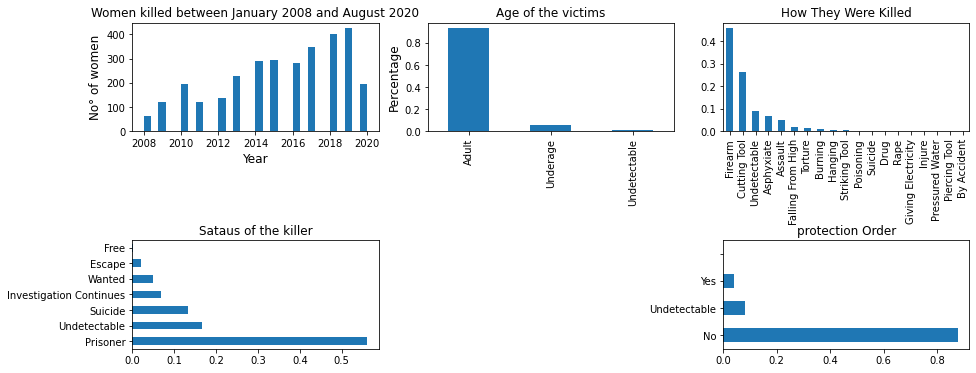

In [8]:
# Data visualization

fig = plt.figure(figsize=(18,6))

# Number of women killed between 2008 and 2020
plt.subplot2grid((2,3),(0,0))
data.year.plot(kind = 'hist' , bins = 30 , figsize = (9,6) , range = (2008 , 2020) )
plt.title('Women killed between January 2008 and August 2020')
plt.xlabel("Year", fontsize = 12)
plt.ylabel("No° of women", fontsize = 12)

# distribution by age
plt.subplot2grid((2,3),(0,1))
data.age.value_counts(normalize=True).plot(kind='bar',figsize = (15,6))
plt.title("Age of the victims")
plt.ylabel("Percentage", fontsize = 12)

# The way they were killed
plt.subplot2grid((2,3),(0,2))
data.killingway1.value_counts(normalize=True).plot(kind='bar',figsize = (15,6))
plt.title("How They Were Killed")

plt.subplots_adjust(hspace=1)

# Sataus of the killer
plt.subplot2grid((2,3),(1,0))
data.statusofkiller.value_counts(normalize=True).plot(kind='barh',figsize = (15,6))
plt.title("Sataus of the killer")

# Protection Order
plt.subplot2grid((2,3),(1,2))
data.protectionorder.value_counts(normalize=True).plot(kind='barh',figsize = (15,6))
plt.title("protection Order")
# plt.show()

### The reason of killings

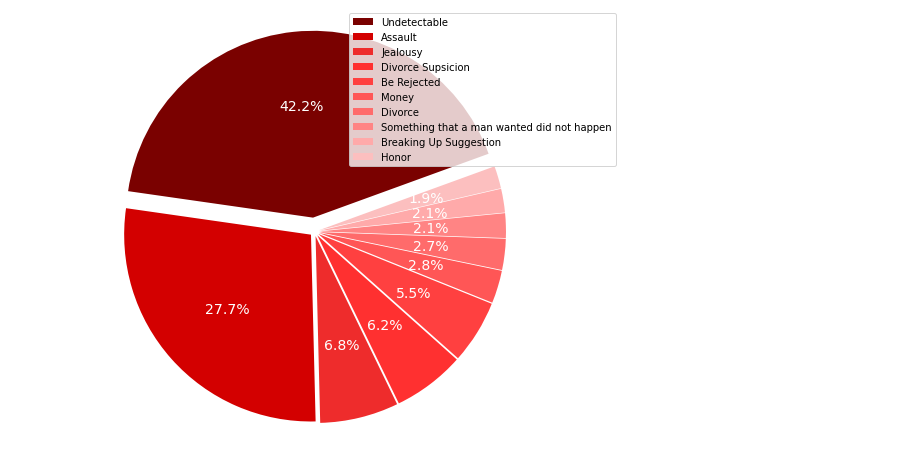

In [9]:
counts = data.why1.value_counts().head(10)
explode = (0.075, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,0.025,0.025,0.025)
colors = ['#7a0100', '#d30000', '#ee2c2c', '#ff3030', '#ff4040', '#ff5656', '#ff6b6b',
          '#ff8484', '#ffaaaa', '#fcbfbf','#00FF80' ,]
index = ['Undetectable','Assault','Jealousy','Divorce Supsicion','Be Rejected','Money','Divorce','Something that a man wanted did not happen','Breaking Up Suggestion','Honor']
counts.plot(kind='pie', fontsize=14, colors=colors, explode=explode,figsize = (11,8), autopct = "%1.1f%%" ,startangle = 20,textprops = dict(color = 'w') )
plt.axis('equal')
plt.ylabel('')
plt.legend(labels = index,loc = 'upper right')
plt.show()

#### Relationship to the killer

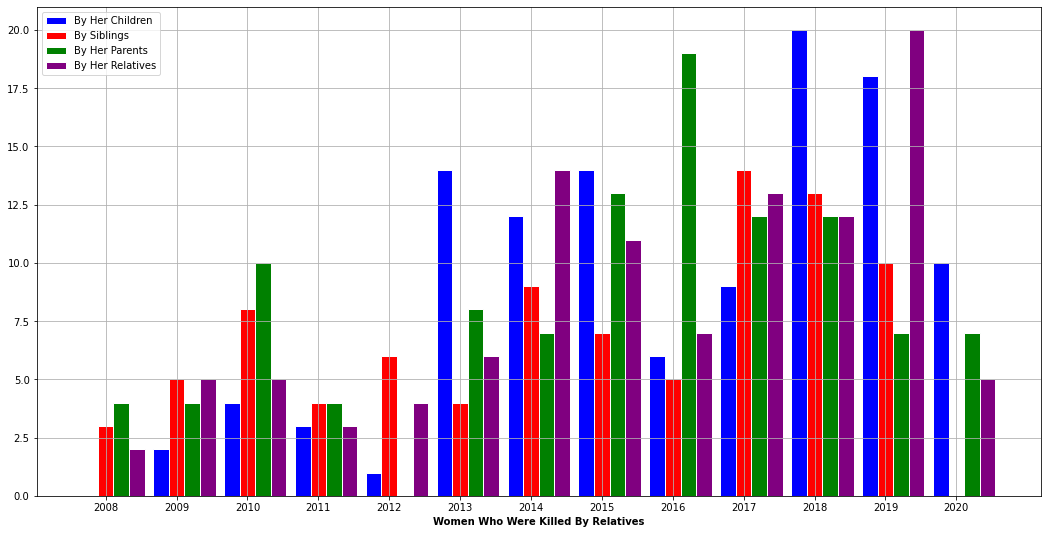

In [10]:
# By her son and her daughter
family1 = data[(data['killer1'] == 'Son') | (data['killer1'] == 'Daughter')]
family1filter = family1[['year','killer1']]
family1filter.year.value_counts().head(13).sort_index()
listfamily1 = list(family1filter.year.value_counts().head(13).sort_index())
listfamily1.insert(0,0) 
#There is no value in 2008, so we added zero value in this year.

#By her brother, sibling and sister
family2 = data[(data['killer1'] == 'Brother') | (data['killer1'] == 'Sibling')| (data['killer1'] == 'Sister') ]
family2filter = family2[['year','killer1']]
family2filter.year.value_counts().head(13).sort_index()
listfamily2 = list(family2filter.year.value_counts().head(13).sort_index())
listfamily2.append(0)

#By her mom and dad
family3 = data[(data['killer1'] == 'Father') | (data['killer1'] == 'Mother') ]
family3filter = family3[['year','killer1']]
family3filter.year.value_counts().head(13).sort_index()
listfamily3 = list(family3filter.year.value_counts().head(13).sort_index())
listfamily3.insert(4,0)

#By her grandson, nephew, uncle, cousin and relatives
family4 = data[(data['killer1'] == 'Grandson' ) | (data['killer1'] == 'Nephew') | (data['killer1'] == 'Uncle') |(data['killer1'] == 'Cousin') | (data['killer1'] == 'Relative')]
family4filter = family4[['year','killer1']]
family4filter.year.value_counts().head(13).sort_index()
listfamily4 = list(family4filter.year.value_counts().head(13).sort_index())

#The data is inserted a list to draw a graph
data_1 = []
data_1.append(listfamily1)
data_1.append(listfamily2)
data_1.append(listfamily3)
data_1.append(listfamily4)
barWidth = 0.22
r1 = np.arange(len(data_1[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

#make the plot and show
plt.figure(figsize=(18,9))
plt.grid(zorder = 0)
plt.bar(r1, data_1[0], color=['blue'], width=barWidth, edgecolor='white', label='By Her Children')
plt.bar(r2, data_1[1] , color=['red'], width=barWidth, edgecolor='white', label='By Siblings')
plt.bar(r3, data_1[2], color=['green'], width=barWidth, edgecolor='white', label='By Her Parents ')
plt.bar(r4, data_1[3], color='purple', width=barWidth, edgecolor='white', label='By Her Relatives')
plt.xlabel('Women Who Were Killed By Relatives', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(data_1[0]))], ['2008', '2009', '2010', '2011', '2012','2013', '2014', '2015', '2016', '2017','2018', '2019', '2020'])
plt.legend()
plt.savefig("Women Who Were Killed By Relatives.png")
plt.show()


In [11]:
# the percentage of women killed by their own children over the years is weirdly high, an average between 10 and 20 case.
# The women killed by their parents are also with a high importance

In [12]:
bywhom = data.killer1.value_counts()
bywhom.head(10)

Husband                      1040
Undetectable                  504
Boyfriend                     306
Someone She Knows             275
Ex Husband                    179
Son                           113
Father                        106
Someone She Does Not Know      90
Brother                        88
Ex Boyfriend                   84
Name: killer1, dtype: int64

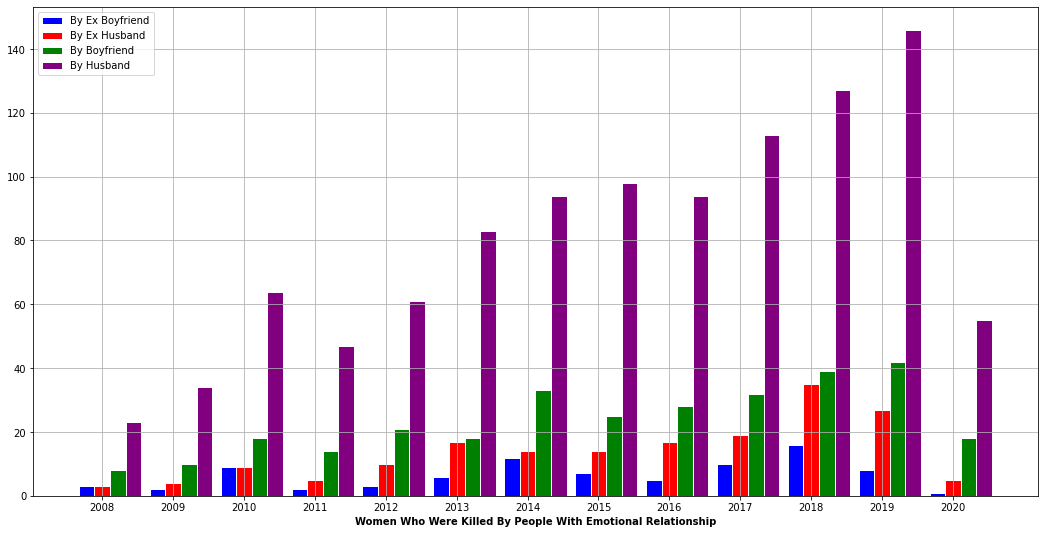

In [13]:
## Women Who Were Killed By People With Emotional Relationship

# By her husband
byhusband = data[data['killer1'] == 'Husband' ]
byhusbandfilter = byhusband[['year','killer1']]
byhusbandfilter.year.value_counts().head(13).sort_index()
listbyhusband = list(byhusbandfilter.year.value_counts().head(13).sort_index())
# By her ex husband
byexhusband = data[data['killer1'] == 'Ex Husband' ]
byexhusbandfilter = byexhusband[['year','killer1']]
byexhusbandfilter.year.value_counts().head(13).sort_index()
listbyexhusband = list(byexhusbandfilter.year.value_counts().head(13).sort_index())
# By her ex boyfriend
byexboyfriend = data[(data['killer1'] == 'Ex Boyfriend') ]
byexboyfriendfilter = byexboyfriend[['year','killer1']]
byexboyfriendfilter.year.value_counts().head(13).sort_index()
listbyexboyfriend= list(byexboyfriendfilter.year.value_counts().head(13).sort_index())
#By her boyfriend
byboyfriend = data[data['killer1'] == 'Boyfriend' ]
byboyfriendfilter = byboyfriend[['year','killer1']]
byboyfriendfilter.year.value_counts().head(13).sort_index()
listbyboyfriend = list(byboyfriendfilter.year.value_counts().head(13).sort_index())
data_2 = []
data_2.append(listbyexboyfriend)
data_2.append(listbyexhusband)
data_2.append(listbyboyfriend)
data_2.append(listbyhusband)
# Axis values
barWidth = 0.22
r1 = np.arange(len(data_2[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
#Make the Plot Show
plt.figure(figsize=(18,9))
plt.grid(zorder = 0)
plt.bar(r1, data_2[0], color=["blue"], width=barWidth, edgecolor='white', label='By Ex Boyfriend')
plt.bar(r2, data_2[1] , color=["red"], width=barWidth, edgecolor='white', label='By Ex Husband')
plt.bar(r3, data_2[2], color=["green"], width=barWidth, edgecolor='white', label='By Boyfriend')
plt.bar(r4, data_2[3], color='purple', width=barWidth, edgecolor='white', label='By Husband')
plt.xlabel('Women Who Were Killed By People With Emotional Relationship', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(data_2[0]))], ['2008', '2009', '2010', '2011', '2012','2013', '2014', '2015', '2016', '2017','2018', '2019', '2020'])
plt.legend()
plt.savefig("Women Who Were Killed By People With Emotional Relationship.png")
plt.show()

In [14]:
#Except for unspecified data, a total of 1040 women were killed by their husbands.

#### killed Women According To City Rates In Turkey

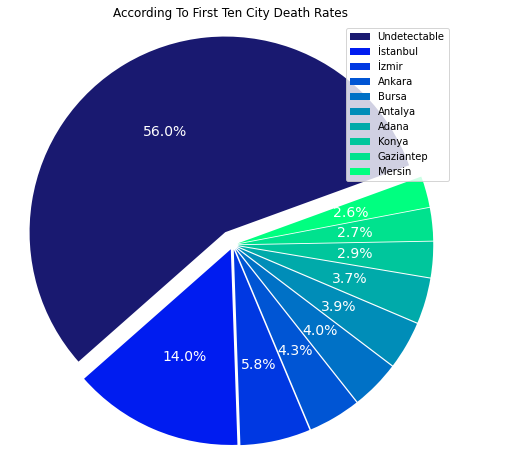

In [15]:
accordingtocities = data.city.value_counts().head(10)
colors = ['#191970', '#001CF0', '#0038E2', '#0055D4', '#0071C6', '#008DB8', '#00AAAA',
          '#00C69C', '#00E28E', '#00FF80','#00FF80' ,]
explode = (0.075, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,0.025, 0.025,0.025)
cities = accordingtocities.plot(kind='pie'  , textprops = dict(color = 'w'),figsize = (8, 8),colors = colors ,explode = explode, startangle = 20 , shadow = False , autopct = "%1.1f%%", fontsize=14)
cities.set_title("According To First Ten City Death Rates")
cities.set_ylabel("" )
indexcities = ['Undetectable','İstanbul','İzmir','Ankara','Bursa','Antalya','Adana','Konya','Gaziantep' , 'Mersin' ]
plt.axis('equal')
plt.legend(labels = indexcities , loc = 'upper right' , fontsize = 10)
plt.ylabel('')
plt.show()

In [16]:
# most of the case the place of muder is undetectable
# in second place the majority of cases are declered in Istanbul 

#### Arima Forcasting model

To predict the sum of the Killings value for the coming years, we are going to use an ARIMA model

In [17]:
count_df =  pd.DataFrame(data.year.value_counts().head(13).sort_index())
count_df

,year
2008,65
2009,123
2010,194
2011,121
2012,139
2013,229
2014,290
2015,295
2016,282
2017,348


In [18]:
print (count_df.sum())

year    3110
dtype: int64


In [74]:
# initialize list of lists
data = [['2008', 65], ['2009', 123], ['2010', 194], ['2011', 121], ['2012', 139], ['2013', 229], ['2014', 290], ['2015', 295], ['2016', 282], ['2017',  348], ['2018', 403], ['2019', 427], ['2020', 194]]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Year', 'Killings'])
 
# print dataframe.
df

,Year,Killings
0,2008,65
1,2009,123
2,2010,194
3,2011,121
4,2012,139
5,2013,229
6,2014,290
7,2015,295
8,2016,282
9,2017,348


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      13 non-null     object
 1   Killings  13 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 336.0+ bytes


In [79]:
df['Year'] = pd.to_datetime(df.Year)

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose

dataTime = df[['Year', 'Killings']].set_index('Year', inplace=False)

dataTimeMean = pd.DataFrame(dataTime.resample('Y')['Killings'].sum()) #resample using weeks as parameter
# dataTimeMean = dataTimeMean.fillna(0)

#Decompose Time Series
decompose = seasonal_decompose(dataTimeMean, extrapolate_trend=25)

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

<AxesSubplot:xlabel='Year', ylabel='resid'>

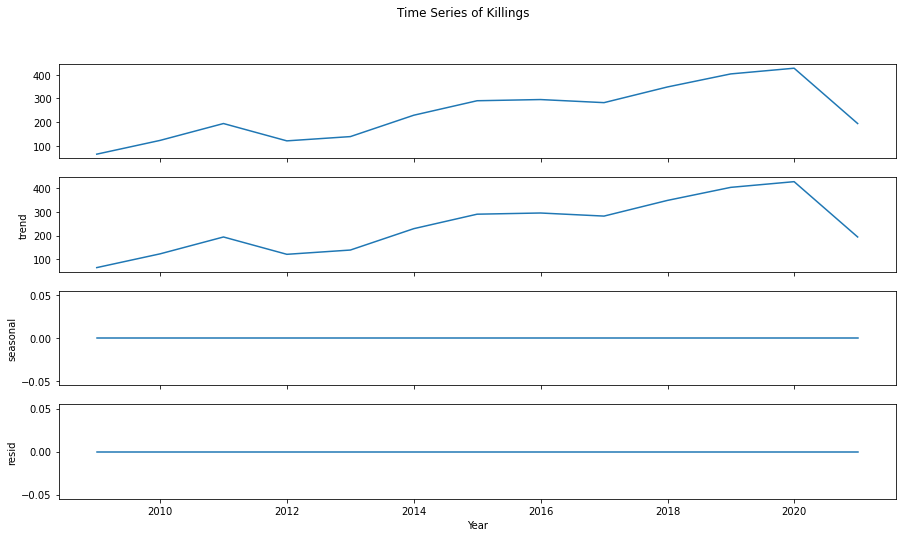

In [102]:
#plot
fig, axes = plt.subplots(4, 1, figsize=(15,8), sharex=True)
fig.suptitle('Time Series of Killings')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=seazon.index, y=seazon, ax=axes[2], data=seazon)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

In [103]:
#Is the data stationary?
adfTest = ADFTest(alpha=0.05)
adfTest.should_diff(dataTimeMean)

(0.6371803503021696, True)

In [104]:
dataTimeMean['x1'] = dataTimeMean.Killings.shift(1)

dataTimeMean.dropna(axis=0, inplace=True)

dataTimeMean.head()

,Killings,x1
Year,,
2009-12-31,123,65.0
2010-12-31,194,123.0
2011-12-31,121,194.0
2012-12-31,139,121.0
2013-12-31,229,139.0


<AxesSubplot:xlabel='Year'>

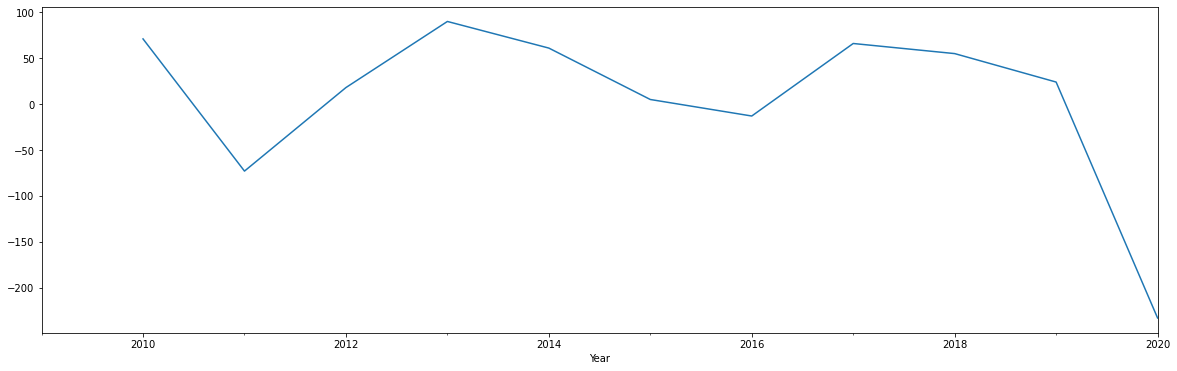

In [106]:
#Making the series stationary
dataTimeMean.Killings.diff(1).plot(figsize=(20, 6))

<AxesSubplot:xlabel='Year'>

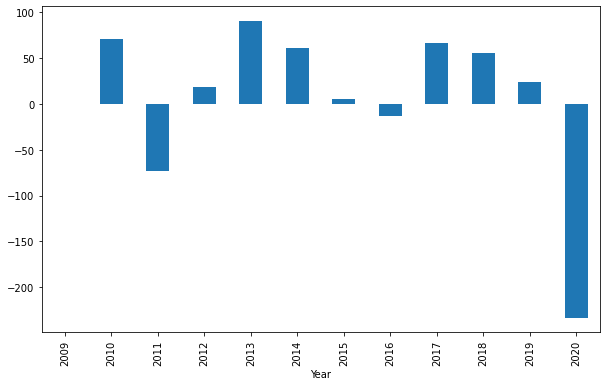

In [109]:
dataTimeMean.Killings.diff(1).groupby(dataTimeMean.index.year).mean().plot(kind='bar', figsize=(10, 6))

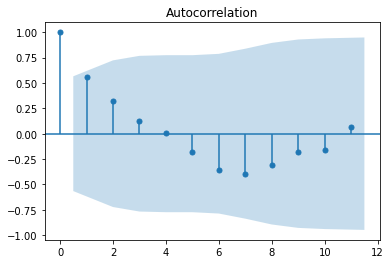

In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataTimeMean.Killings)
plt.show()

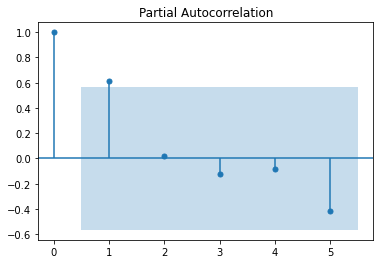

In [113]:
plot_pacf(dataTimeMean.Killings, lags=5)
plt.show()

As observed on Partial Autocorrelation plot, a shift of 1 will be sufficient for a regression model. So, we will create this new feature to apply a regression model to forecast nextyears killings counts.

#### Find the best regression model

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = dataTimeMean[['x1']]
y = dataTimeMean.Killings.values

linearRegression = LinearRegression().fit(X, y)
predictionsLinear = linearRegression.predict(X)

print('RMSE for Linear Regression was: \n', mean_squared_error(y, predictionsLinear, squared=False))

RMSE for Linear Regression was: 
 73.0749132447429


In [115]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=150, learning_rate=0.05)
xgb.fit(X, y, 
        early_stopping_rounds=5, 
        eval_set=[(X, y)], 
        verbose=False
)

predictions_XGBoost = xgb.predict(X)

print('RMSE for xgb was: \n', mean_squared_error(y, predictions_XGBoost, squared=False))

RMSE for xgb was: 
 3.2508911686665627


In [118]:
from sklearn.ensemble import RandomForestRegressor
randomF = RandomForestRegressor(n_estimators = 500, random_state=0).fit(X, y)

predictions_RandomForest = randomF.predict(X)
print('RMSE for Random Forest was: \n', mean_squared_error(y, predictions_RandomForest, squared=False))

RMSE for Random Forest was: 
 33.29599214119721


So, we will choose XGB Regressor.

<AxesSubplot:xlabel='Year'>

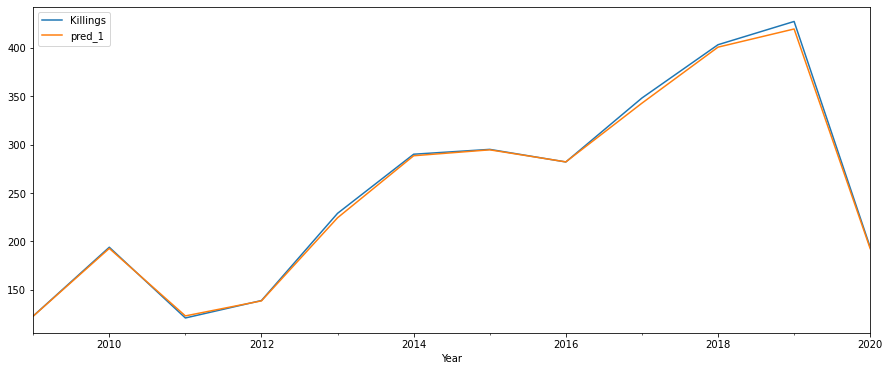

In [119]:
dataTimeMean['pred_1'] = xgb.predict(X)
dataTimeMean[['Killings', 'pred_1']].plot(figsize=(15, 6))

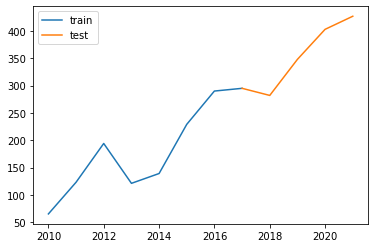

In [121]:
train_size = int(len(dataTimeMean.Killings) * 2 / 3)

train = X[:train_size]
test = X[train_size-1:]

plt.plot(train)
plt.plot(test)
plt.legend(['train', 'test'])

Let's see how the model XGB Regressor fits on unseen data (test set)

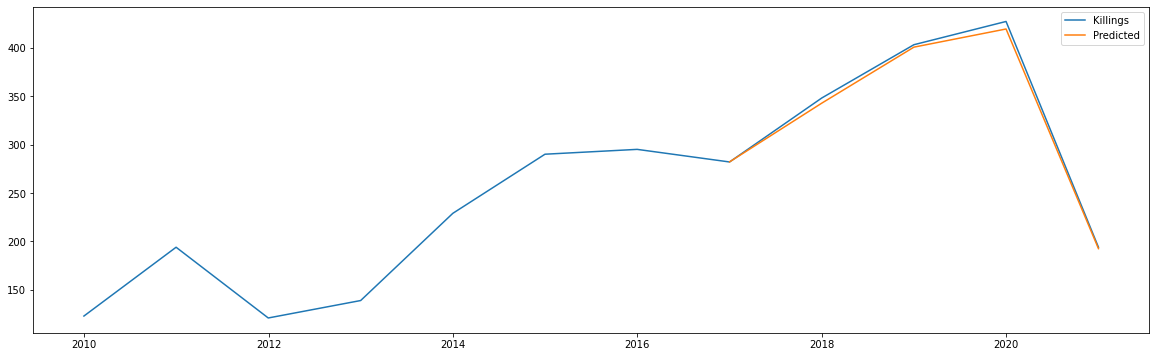

In [122]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.Killings)
forecast = xgb.predict(test)
plt.plot(test.index, forecast)
plt.legend(['Killings', 'Predicted'])

We will now forecast the next year's "killings count" feature, using the trainned XGB model

In [124]:
LastCount = dataTimeMean['Killings'][-1]

datesToPredict = pd.Series(dataTimeMean.index[-1] + pd.Timedelta('1 Y'))

forecastData =  pd.DataFrame({'x1': str(LastCount)}, index=datesToPredict)  
forecastData.x1 = pd.to_numeric(forecastData.x1)


print("Next Years's predicted killings is: R$", xgb.predict(forecastData))

Next Years's predicted killings is: R$ [123.13941]


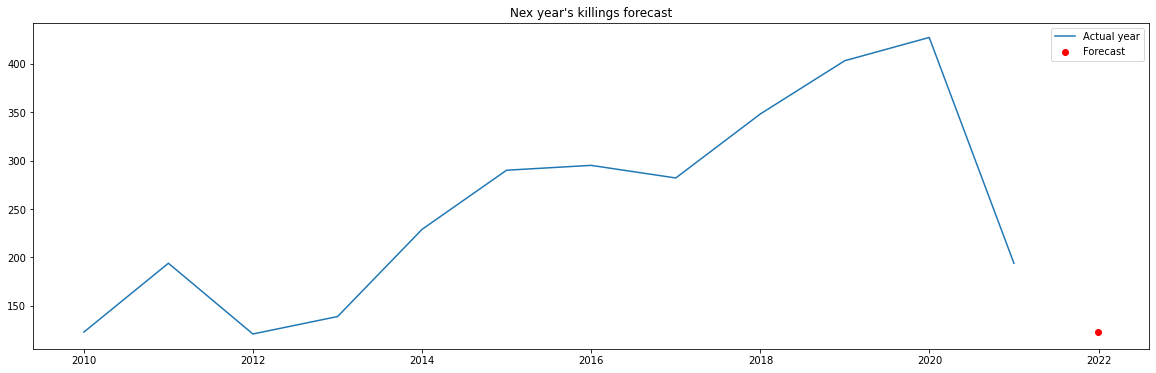

In [125]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.Killings)
forecast = xgb.predict(test)
plt.scatter(forecastData.index, xgb.predict(forecastData), color='red')
plt.title("Nex year's killings forecast")
plt.legend(['Actual year', 'Forecast'])

### Applying auto-ARIMA model as an option for goal defining for next years

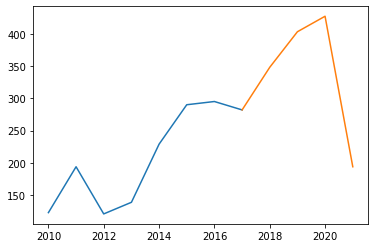

In [126]:
#Delete data generated from XGB
dataTimeMean = dataTimeMean.drop(columns=['pred_1', 'x1'], axis=0)

train = dataTimeMean[:train_size]
test = dataTimeMean[train_size-1:]

plt.plot(train)
plt.plot(test)

In [127]:
autoArimaModel = auto_arima(train, freq="Y", seazonal=False, 
                            trace=False, random_state=1, n_fits=50)

autoArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    8
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -43.393
Date:                Wed, 08 Jun 2022   AIC                             92.785
Time:                        17:42:28   BIC                             93.023
Sample:                             0   HQIC                            91.178
                                  - 8                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     65.1517     87.850      0.742      0.458    -107.031     237.334
ar.L1          0.6849      0.454      1.508      0.132      -0.205       1.575
sigma2      2782.9616   2790.163      0.997      0.319   -2685.657    8251.580
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.98   Prob(JB):                         0.68
Heteroskedasticity (H):               0.50   Skew:                            -0.52
Prob(H) (two-sided):                  0.58   Kurtosis:                         1.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
dateRange = pd.date_range(dataTimeMean.index[-1], freq='Y', periods=11)[1:]

predict = pd.DataFrame(autoArimaModel.predict(n_periods=len(dateRange)), index=dateRange)
predict.columns = ['Killings']
predict.year = predict.Killings.round(2)

print('Next years pridiction from auto-ARIMA')
print(predict.Killings)

Next years pridiction from auto-ARIMA
2021-12-31    258.305393
2022-12-31    242.075960
2023-12-31    230.959738
2024-12-31    223.345771
2025-12-31    218.130645
2026-12-31    214.558585
2027-12-31    212.111931
2028-12-31    210.436115
2029-12-31    209.288279
2030-12-31    208.502077
Freq: A-DEC, Name: Killings, dtype: float64


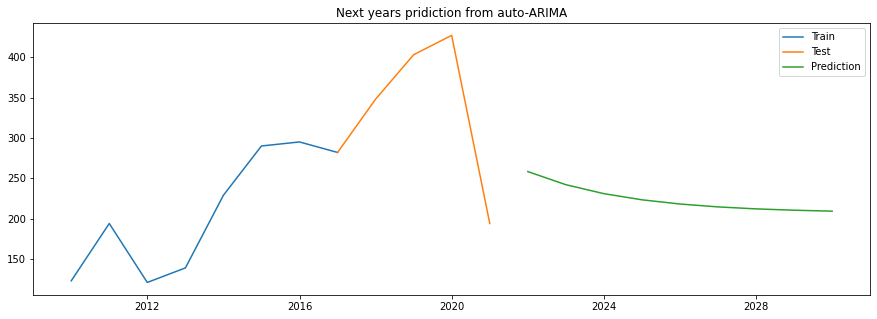

In [130]:
plt.figure(figsize=(15,5))
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.title('Next years pridiction from auto-ARIMA')
plt.legend(loc='best')
plt.show()